In [1]:
# Import the required packages
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
from dateutil import rrule
from dateutil.relativedelta import relativedelta
import yfinance as yf
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
yf.pdr_override()

In [2]:
# Get stock data
tickers = ['BTC-USD', 'ETC-USD', 'LTC-USD', 'XMR-USD', 'NEO-USD', 'XRP-USD', 'ZEC-USD']
df = pd.read_csv("stock.csv")

In [3]:
# Find two co-integrated stocks and return the second variable, which is the pValue of the co-integration pair
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    min_value = 1
    min_pair = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
                if pvalue < min_value:
                    min_value = pvalue
                    min_pair=[keys[i], keys[j]]            
    return score_matrix, pvalue_matrix, pairs, min_pair

In [4]:
# Calculate returns
def trade(split, b, S1, S2, window1, window2, principal, trade_times, show_pic):
    if (window1 == 0) or (window2 == 0):
        return 0
    
    target = b * S1 - S2
    
    if show_pic:
        target[:split].plot(figsize=(12,6))
        plt.axhline(target[:split].mean())
        plt.title(u'train dataset: b * S1 - S2')
        plt.show()
        
    
    ma1 = target.rolling(window=window1,
                               center=False).mean()
    ma2 = target.rolling(window=window2,
                               center=False).mean()
    std = target.rolling(window=window1,
                        center=False).std()
    zscore = (ma2 - ma1)/std
    
    
    if show_pic:
        zscore[:split].plot(figsize=(12,6))
        plt.axhline(zscore[:split].mean())
        plt.title(u'train dataset: b * S1 - S2 zscore')
        plt.show()
    
    open_signal = pd.Series([] * len(S1))
    open_signal = pd.Series([] * len(S1))
    close_signal = pd.Series([] * len(S1))
    
    
    open_signal2 = pd.Series([] * len(S1))
    open_signal2 = pd.Series([] * len(S1))
    close_signal2 = pd.Series([] * len(S1))

    countS1 = 0
    countS2 = 0
    S1_o = 0
    S2_o = 0
    has_socket = 0
    rets = 0
    k = 0
    
    for i in range(split, len(target)):

        if trade_times is not None and k>=trade_times:
            break
        # short sell S2
        if zscore[i] < -1 and has_socket==0:
            if target[i] > 0:
                countS1 = principal / S1[i]
                countS2 = -countS1 / b
            else:
                countS2 = -principal / S2[i]
                countS1 = -countS2 * b
                
            has_socket = 1
            S1_o = S1[i]
            S2_o = S2[i]
            
            open_signal[i] = zscore[i]
            open_signal2[i] = target[i]
        
        # short sell S1
        elif zscore[i] > 1 and has_socket==0:
            if target[i] > 0:
                countS1 = -principal / S1[i]
                countS2 = -countS1 / b
            else:
                countS2 = principal / S2[i]
                countS1 = -countS2 * b
            
            has_socket = 2
            S1_o = S1[i]
            S2_o = S2[i]
            
            open_signal[i] = zscore[i]
            open_signal2[i] = target[i]
             
        #elif abs(zscore[i]-zscore.mean()) < 0.3 and has_socket:
        #elif (zscore[i]==1) and has_socket:
        #elif i>split and zscore[i-1]*zscore[i]<=0 and has_socket:
        elif (has_socket==1 and zscore[i]>-0.1) or (has_socket==2 and zscore[i]<0.1): 
            k+=1
            #print("the{}th trading，return:{}".format(k, countS1 * (S1[i] - S1_o) + countS2 * (S2[i] - S2_o)))
            
#             print("shares:", countS1, countS2)
#             print("buy price:", S1_o,  S2_o)
#             print("sell price:", S1[i], S2[i])
#             print("return A:{}, B:{}".format(countS1 * (S1[i] - S1_o),countS2 * (S2[i] - S2_o)))
#             print("================")

            has_socket = 0
            rets += countS1 * (S1[i] - S1_o) + countS2 * (S2[i] - S2_o)
            countS1 = 0
            countS2 = 0
            S1_o = 0
            S2_o = 0
            close_signal[i] = zscore[i]
            close_signal2[i] = target[i]
            
            
    # print("the{}th trading，reuturn:{}".format(k+1, countS1 * (S1[-1] - S1_o) + countS2 * (S2[-1] - S2_o)))
    rets += countS1 * (S1[-1] - S1_o) + countS2 * (S2[-1] - S2_o)

    if show_pic:
        zscore.plot(figsize=(12,6))
        open_signal.plot(color='r', linestyle='None', marker='^')
        open_signal.plot(color='r', linestyle='None', marker='^')
        close_signal.plot(color='g', linestyle='None', marker='^')
        plt.title(u'all dataset: b * S1 - S2 and zscore')
        #plt.show()

        target.plot(figsize=(12,6))
        open_signal2.plot(color='r', linestyle='None', marker='^')
        open_signal2.plot(color='r', linestyle='None', marker='^')
        close_signal2.plot(color='g', linestyle='None', marker='^')
        plt.show()
    
    return principal, rets

In [5]:
def main(start_date, end_date, train_date_len, test_date_len=None, trade_times=None, long_win=30, short_win=5, principal=None, select=None):
    rets_list = []
    pairs_list = []
    
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d').date()
    month_num = rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date).count()//train_date_len

    date_list = [start_date]
    date = start_date
    for i in range(month_num-1):
        date = date+relativedelta(months=+train_date_len)
        date_list.append(date)
    date_list = list(map(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"), date_list))
    
    
    print("set date：")
    print(date_list)
    print()
    print()
    
    for i in range(len(date_list)-1):
        if select is not None and i!=select:
            continue
            
        start_date = date_list[i]
        end_date = date_list[i+1]
        df_cur = df
        df_cur = df_cur[df_cur["Date"] >= start_date]
        df_cur = df_cur[df_cur["Date"] < end_date]

        # Choose test data set
        df_next = df
        df_next = df_next[df_next["Date"] >= end_date]
        if test_date_len is not None:
            end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d').date()
            next_date = end_date + relativedelta(days=+test_date_len)
            next_date = datetime.datetime.strftime(next_date, "%Y-%m-%d")
            df_next = df_next[df_next["Date"] < next_date]
        
        split = len(df_cur)
        df_all = pd.concat([df_cur, df_next], axis=0)
        df_all["Date2"] = df_all['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())
        df_all.sort_values(by="Date2", inplace=True, ascending=True)
        df_all.set_index('Date', inplace=True)
        
        # The smaller the pvalue, the higher the integration degree
        df_cur.set_index('Date', inplace=True)
        scores, pvalues, pairs, min_pair = find_cointegrated_pairs(df_cur)

        if len(min_pair)==0:
            rets_list.append(0)
            pairs_list.append([])
            continue

        # Select an integration pair
        name1 = min_pair[0]
        name2 = min_pair[1]
        
        # Calculate b
        # OLS for polynomial fitting
        S1= df_cur[name1]
        S2= df_cur[name2]
        S1 = sm.add_constant(S1)
        results = sm.OLS(S2, S1).fit() 
        S1 = S1[name1]
        b = results.params[name1]
        
        print("【{}】the first stock:{}, the second stock：{}，b = {}".format(i, name1, name2, b))
        print("Train data:{}     {}".format(date_list[i], date_list[i+1]))
        if test_date_len is not None:
            print("Trade date:{}     {}".format(end_date, next_date))
        else:
            print("Trade date:{}     0".format(end_date))
        
        principal, rets = trade(split, b, df_all[name1], df_all[name2], long_win, short_win, principal, trade_times, select is not None)
        
        t1 = df_all[name1]*b
        t2 = df_all[name1]
        if select is not None:
            t1.plot(figsize=(12,6))
            t2.plot(figsize=(12,6))
            plt.title(u'two sockets')
            plt.show()
        
        print("principal:{}，return:{}，rate:{}".format( principal, rets, rets/principal))
        print()
        print()
        rets_list.append(rets)
        pairs_list.append([name1, name2])
            
    return rets_list
        


# Parameters
* The first two times are the start and end times of the data
* train_date_len：train data set length
* test_date_len：test data set length
* trade_times：The limit of the number of times we trade in each turn. None indicates that there is no limit on the number of trades in test data set
* principal：Limit of the amount of securities and principal
* select：Select the number of attempts to find the problem, None means not to find the problem, show all results

In [6]:
rets_list = main("2018-01-01", "2021-12-31", train_date_len=3, test_date_len=90, trade_times=2, long_win=30, short_win=2, principal=1000000, select=None
                )
print("=============================================================================================")
total = 0
for i in rets_list:
    total += i
print("total returns：{}".format(total))

set date：
['2018-01-01', '2018-04-01', '2018-07-01', '2018-10-01', '2019-01-01', '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01', '2021-01-01', '2021-04-01', '2021-07-01', '2021-10-01']


【0】the first stock:BTC-USD, the second stock：XRP-USD，b = 0.0002523247340275961
Train data:2018-01-01     2018-04-01
Trade date:2018-04-01     2018-06-30
principal:1000000，return:80887.62831836409，rate:0.08088762831836409


【1】the first stock:XMR-USD, the second stock：NEO-USD，b = 0.3224362514235509
Train data:2018-04-01     2018-07-01
Trade date:2018-07-01     2018-09-29
principal:1000000，return:273280.9241414736，rate:0.2732809241414736


【2】the first stock:BTC-USD, the second stock：ETC-USD，b = 0.0021399718638831504
Train data:2018-07-01     2018-10-01
Trade date:2018-10-01     2018-12-30
principal:1000000，return:-23837.126814773233，rate:-0.023837126814773235


【3】the first stock:ETC-USD, the second stock：NEO-USD，b = 1.760055307581453
Train data:2018-10-

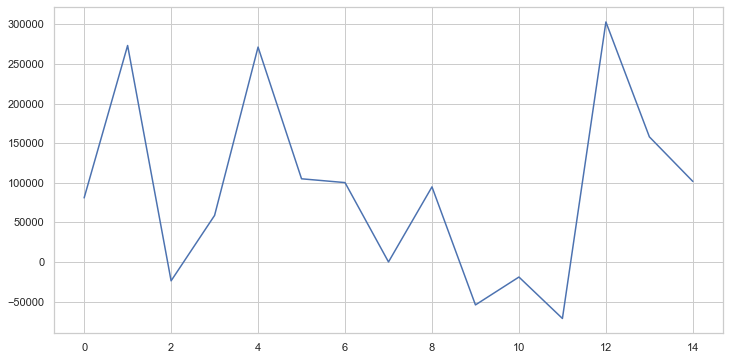

In [7]:
## pictures of returens for each transaction cycle
plt.figure(figsize = (12, 6))
plt.plot(rets_list)

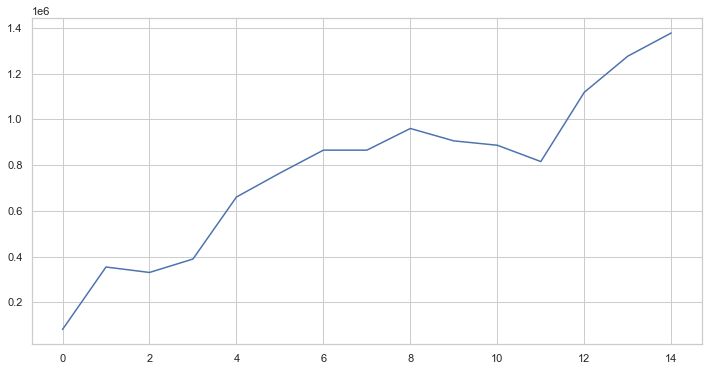

In [8]:
## pictures of accumulative returns from the first transaction cycle to the last
rets_acc = np.array(rets_list).cumsum(0)
plt.figure(figsize = (12, 6))
plt.plot(rets_acc)